In [2]:
pwd()

'C:\\Users\\itsni\\Downloads'

In [3]:
%cd D:\ComputerVisionDatasets

D:\ComputerVisionDatasets


In [4]:
pwd()

'D:\\ComputerVisionDatasets'

In [5]:
# Importing all necessary libraries
from os import makedirs
from os import listdir
from shutil import copyfile

### Extract all the files from Zip

In [6]:
from zipfile import ZipFile

with ZipFile('dogs-vs-cats.zip','r') as zipobj:
  # Extract all the contents of zip file in current directory
  zipobj.extractall()

with ZipFile('train.zip','r') as zipobj:
  # extract all the contents of zip file in current directory
  zipobj.extractall()

with ZipFile('test1.zip','r') as zipobj:
  #extract all the contents of zip file in current directory
  zipobj.extractall()

Creating sub directories so the data is in this format

-dataset_dogs_vs_cats

    -train
      --dogs
      --cats
    -test
      --dogs
      --cats

In [7]:
#create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs=['train/','test/']
for subdir in subdirs:
  #create label subdirectories
  labeldirs=['dogs/','cats/']
  for labeldir in labeldirs:
    newdir = dataset_home+subdir+labeldir
    makedirs(newdir,exist_ok=True)

Now change your dataset to fit this format

In [8]:

#create directories
from random import seed,random
seed(1)
#define ratio of picture to use for validation
val_ratio=0.25

# copy training dataset images into subdirectories
src_directory = 'train'
dataset_home='dataset_dogs_vs_cats/'
for file in listdir(src_directory):
  src = src_directory+'/'+file
  dst_dir='train/'
  if random()<val_ratio:
    dst_dir='test/'
  if file.startswith('cat'):
    dst=dataset_home+dst_dir+'cats'+file
    copyfile(src,dst)
  elif file.startswith('dog'):
    dst=dataset_home+dst_dir+'dogs/'+file
    copyfile(src,dst)

### Prepare a model for transfer learning

In [9]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
model = VGG16(include_top=False,input_shape=(224,224,3))
#mark loaded layers as not trainable
for layer in model.layers:
  layer.trainable=False
# add new classifier layers
flat1=Flatten()(model.layers[-1].output)
class1=Dense(128,activation='relu',kernel_initializer='he_uniform')(flat1)
output = Dense(1,activation='sigmoid')(class1)

#define new model
model=Model(inputs=model.inputs,outputs=output)
#compile model
opt = SGD(learning_rate=0.001,momentum=0.9)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

Run the model using generator

In [10]:
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68,116.779,103.939]
# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',class_mode='binary',batch_size=64, target_size=(224,224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',class_mode='binary',batch_size=64, target_size=(224,224))

# fit model
history = model.fit_generator(train_it,steps_per_epoch=len(train_it),validation_data=test_it,validation_steps=len(test_it),epochs=3,verbose=1)

Found 9374 images belonging to 2 classes.
Found 3126 images belonging to 2 classes.


C:\Users\itsni\AppData\Local\Temp/ipykernel_18556/2298134737.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it,steps_per_epoch=len(train_it),validation_data=test_it,validation_steps=len(test_it),epochs=3,verbose=1)


Epoch 1/3
147/147 [==============================] - 2435s 17s/step - loss: 0.0949 - accuracy: 0.9943 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
147/147 [==============================] - 2408s 16s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
147/147 [==============================] - 2477s 17s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


Plot the loss and Accuracy

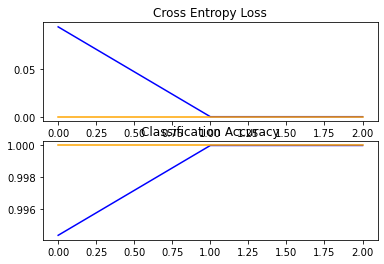

In [11]:
import matplotlib.pyplot as pyplot
import sys
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'],color='blue',label='train')
pyplot.plot(history.history['val_loss'],color='orange',label='test')
#plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'],color='blue',label='train')
pyplot.plot(history.history['val_accuracy'],color='orange',label='test')
#save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename+'_plot.png')

Predict outputs from the model

In [13]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

#load and prepare the image
#load the image
img=load_img('catscat.86.jpg',target_size=(224,224))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels

img = img.reshape(1,224,224,3)
#center pixel data
img = img.astype('float32')
img= img - [123.68,116.779,103.939]

In [14]:
result = model.predict(img)
print(result[0])

[1.]


Save the model for future use

In [15]:
model.save('final_model.h5')
result= model.predict(img)
print(result[0])

[1.]
